In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from scripts.insar_conversion import convert_insar_to_u
import numpy as np
from scipy.optimize import curve_fit

### Import mining region

In [2]:
# --- Read shapefile ---
shp_area = r"maps\concessions_SL\Concessions_SL_area_v1.shp"
gdf_area = gpd.read_file(shp_area)

# Ensure shapefile is in lat/lon
gdf_area = gdf_area.to_crs(epsg=4326)

### Import GNSS

In [3]:
# --- Load ---
path = "gnss/gnss_data.csv"
df = pd.read_csv(path)

# --- Parse + clean ---
df["dates"] = pd.to_datetime(df["dates"], errors="coerce")
df = df.dropna(subset=["dates"])  # drop rows with bad dates

In [4]:
df.head()

,pnt_id,pnt_name,pnt_lat,pnt_lon,pnt_xrd,pnt_yrd,dates,n,e,u,sn,se,su
0,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2002-11-20,0.000426,0.007671,0.005879,0.000932,0.000673,0.002627
1,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-12,0.000447,-0.001009,-0.005334,0.000888,0.000654,0.002506
2,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-11,0.000381,0.000116,-0.005035,0.000889,0.000652,0.002511
3,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-10,0.000678,-0.001208,-0.006365,0.000893,0.000657,0.002522
4,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-09,-0.000864,-0.002044,-0.009819,0.000904,0.000663,0.002558


### Import InSAR

In [5]:
loc_asc = r'insar/sentinel1_asc_t088_limburg.csv'
loc_dsc = r'insar/sentinel1_dsc_t037_limburg.csv'

insar_asc_LOS = pd.read_csv(loc_asc, sep=',')
insar_dsc_LOS = pd.read_csv(loc_dsc, sep=',')

In [6]:
insar_asc_u = convert_insar_to_u(insar_asc_LOS)
insar_dsc_u = convert_insar_to_u(insar_dsc_LOS)

In [7]:
# # Extract the dates from the .csv file
insar_dates = pd.to_datetime(insar_asc_u.filter(regex='^u_20').columns, format='u_%Y%m%d')

# # Extract the displacement data from the .csv file
disp_asc_u = insar_asc_u.filter(regex='^u_20')
disp_asc_d = insar_asc_LOS.filter(regex='^d_20')

# Calculate the nr of days between the observations where the first observations is day 0
days = (insar_dates - insar_dates[0]).days
years = days/365

### Plot all data

C:\Users\Nigel\AppData\Local\Temp\ipykernel_26344\2784325883.py:52: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


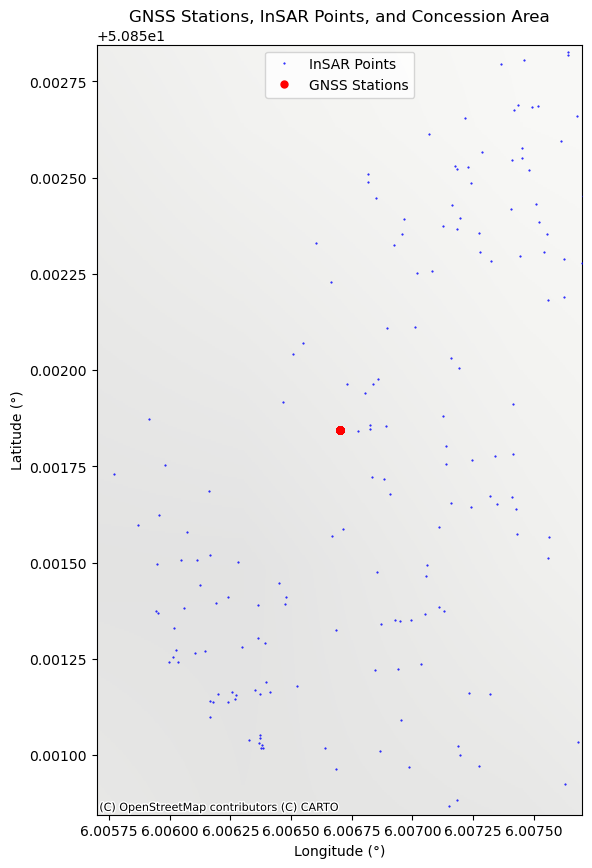

In [8]:
# --- Create figure ---
fig, ax = plt.subplots(figsize=(10, 10))

# --- Plot concession area ---
gdf_area.plot(
    ax=ax,
    edgecolor="black",
    facecolor="none",
    linewidth=1.5,
    zorder=2,
    label="Concession Area"
)

# --- Plot InSAR points ---
ax.plot(
    insar_asc_u.pnt_lon,
    insar_asc_u.pnt_lat,
    ".",
    color="blue",
    markersize=1,
    alpha=1,
    label="InSAR Points",
    zorder=3
)

# --- Plot GNSS stations ---
ax.plot(
    df["pnt_lon"],
    df["pnt_lat"],
    "o",
    color="red",
    markersize=5,
    label="GNSS Stations",
    zorder=4
)

# --- Add GNSS station labels ---
# for name in df["pnt_name"].unique():
#     subset = df[df["pnt_name"] == name]
#     ax.text(
#         subset["pnt_lon"].iloc[0],
#         subset["pnt_lat"].iloc[0],
#         name,
#         fontsize=8,
#         zorder=5
#     )

# --- Labels & title ---
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("GNSS Stations, InSAR Points, and Concession Area")
ax.legend()

station_name = "Kerkrade"
buffer = 0.001

st = df.loc[df["pnt_name"] == station_name].iloc[0]
x0, y0 = st["pnt_lon"], st["pnt_lat"]

xmin, xmax = x0 - buffer, x0 + buffer
ymin, ymax = y0 - buffer, y0 + buffer

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)


#label only stations inside current view
# df_view = df[(df["pnt_lon"].between(xmin, xmax)) & (df["pnt_lat"].between(ymin, ymax))]

# for name in df_view["pnt_name"].unique():
#     s = df_view[df_view["pnt_name"] == name].iloc[0]
#     ax.text(s["pnt_lon"], s["pnt_lat"], name, fontsize=8, zorder=10, clip_on=True)

#--- Add basemap (NO API KEY REQUIRED) ---
ctx.add_basemap(
    ax,
    crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron,
    zoom=10
)

plt.show()


In [9]:
def haversine_m(lat1, lon1, lat2, lon2):
    """
    Great-circle distance between (lat1, lon1) and (lat2, lon2) in meters.
    Inputs can be scalars or numpy arrays.
    """
    R = 6371000.0  # Earth radius [m]
    lat1 = np.deg2rad(lat1); lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2); lon2 = np.deg2rad(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def find_nearest_insar_points(insar_df, lat_0, lon_0, N=5,
                              lat_col="pnt_lat", lon_col="pnt_lon"):
    """
    Returns the N nearest InSAR points to (lat_0, lon_0) with distances in meters.
    """
    lat = insar_df[lat_col].to_numpy()
    lon = insar_df[lon_col].to_numpy()

    dist_m = haversine_m(lat_0, lon_0, lat, lon)
    nearest_idx = np.argsort(dist_m)[:N]

    out = insar_df.iloc[nearest_idx].copy()
    out["dist_m"] = dist_m[nearest_idx]
    return out.sort_values("dist_m")

In [10]:
station_name = 'Kerkrade'
lat_0 = df.loc[df['pnt_name'] == station_name, 'pnt_lat'].values[0]
lon_0 = df.loc[df['pnt_name'] == station_name, 'pnt_lon'].values[0]

print(f"{station_name} coordinates: lat={lat_0}, lon={lon_0}")


N = 5

# Use the DataFrame that still has metadata columns (pnt_lat/pnt_lon) + u_ columns.
# For example: insar_asc_u = add_vertical_insar(insar_asc) or convert_insar_to_u(insar_asc_LOS)
nearest = find_nearest_insar_points(insar_asc_u, lat_0, lon_0, N=N)

display(nearest[["pnt_id", "pnt_lat", "pnt_lon", "dist_m"]].head(N))

print(len(nearest))

Kerkrade coordinates: lat=50.851845, lon=6.0067


,pnt_id,pnt_lat,pnt_lon,dist_m
52106,L00012592P00029966,50.851842,6.006776,5.318895
52107,L00012592P00029967,50.851847,6.006823,8.672079
52105,L00012592P00029965,50.851858,6.006824,8.840901
52620,L00012593P00029967,50.851940,6.006803,12.815405
52619,L00012593P00029966,50.851964,6.006731,13.381351


5


In [11]:
def plot_gnss_insar_locations(insar_df, nearest_df, lat_0, lon_0,
                              lat_col="pnt_lat", lon_col="pnt_lon"):
    """
    Plot GNSS location and nearest InSAR points in lon-lat space.
    """
    plt.figure(figsize=(6, 6))

    # Nearest InSAR points
    plt.scatter(
        nearest_df[lon_col],
        nearest_df[lat_col],
        s=80,
        c="tab:blue",
        marker="o",
        label="Nearest InSAR points"
    )

    # GNSS station
    plt.scatter(
        lon_0,
        lat_0,
        s=120,
        c="red",
        marker="*",
        label="GNSS station"
    )

    # Annotate distances (optional but useful)
    for _, row in nearest_df.iterrows():
        plt.text(
            row[lon_col],
            row[lat_col],
            f"{row['dist_m']:.0f} m",
            fontsize=8,
            ha="left",
            va="bottom"
        )

    plt.xlabel("Longitude [deg]")
    plt.ylabel("Latitude [deg]")
    plt.title("GNSS station and nearest InSAR points")
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


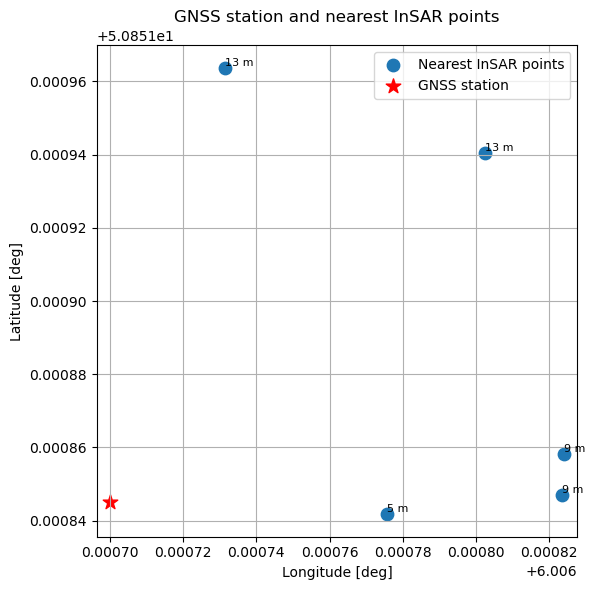

In [12]:
plot_gnss_insar_locations(
    insar_df=insar_asc_u,   # full InSAR DF with lat/lon
    nearest_df=nearest,     # output from find_nearest_insar_points
    lat_0=lat_0,
    lon_0=lon_0
)


In [13]:
# Extract displacement time series for nearest InSAR points
u_cols = insar_asc_u.filter(regex=r"^u_20").columns
disp_nearest_u = insar_asc_u.loc[nearest.index, u_cols]  # shape (N, n_times)

insar_mean_u = disp_nearest_u.mean(axis=0)  # Series indexed by u_YYYYMMDD columns
insar_mean_u = insar_mean_u.to_numpy()

C:\Users\Nigel\AppData\Local\Temp\ipykernel_26344\3587046566.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


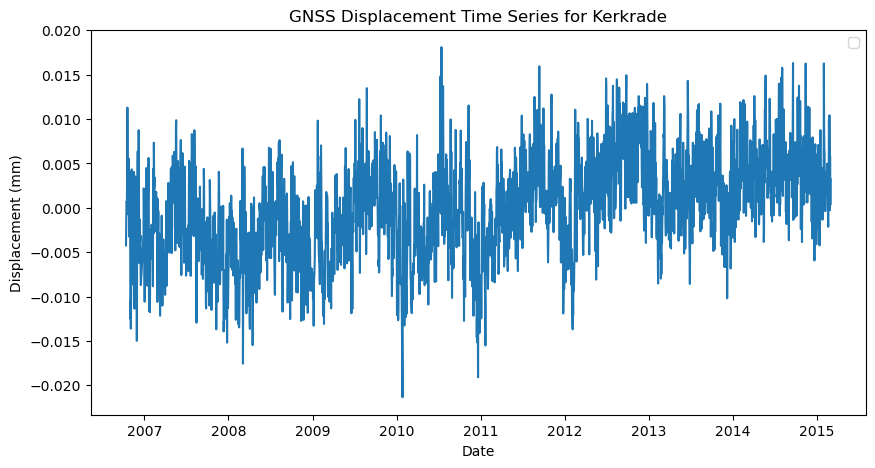

In [14]:
# Kerkrade time series

series_kerkrade = df[df["pnt_name"] == station_name].copy()
series_kerkrade_sorted = series_kerkrade.sort_values(by="dates")

gnss_dates = series_kerkrade_sorted["dates"]
gnss_u = series_kerkrade_sorted["u"].values

plt.figure(figsize=(10, 5))
plt.plot(gnss_dates, gnss_u)
plt.xlabel("Date")
plt.ylabel("Displacement (mm)")
plt.title(f"GNSS Displacement Time Series for {station_name}")
plt.legend()
plt.show()

# Combine with InSAR dataset

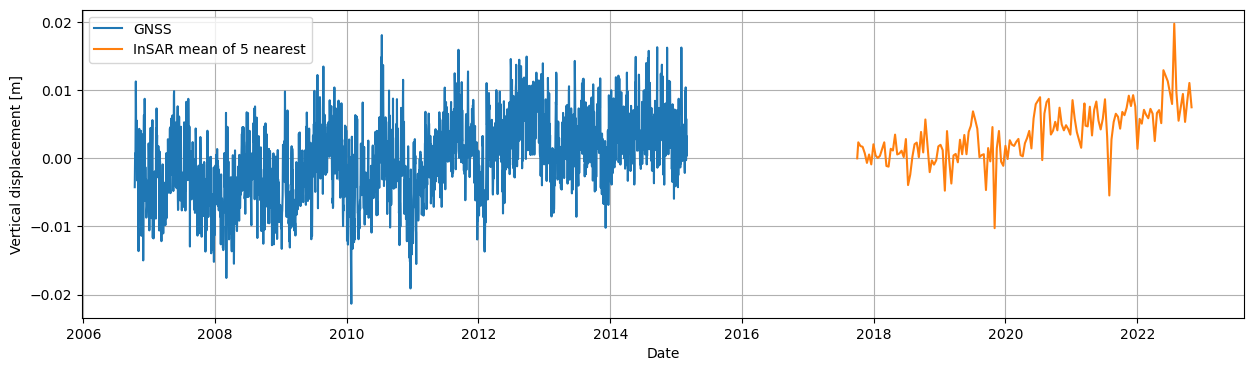

In [15]:
# Convert InSAR mean to numpy aligned with dates
plt.figure(figsize=(15,4))
plt.plot(gnss_dates, gnss_u, label="GNSS")
plt.plot(insar_dates, insar_mean_u, label=f"InSAR mean of {N} nearest")
plt.xlabel("Date")
plt.ylabel("Vertical displacement [m]")
plt.grid(True)
plt.legend()
plt.show()


# Fit linear trend model

Setup time vectors

In [16]:
gnss_t = (gnss_dates - gnss_dates.iloc[0]).dt.days.values
print(gnss_t)

insar_t = (insar_dates - gnss_dates.iloc[0]).days.values
print(insar_t)

t = np.arange(gnss_t[0], insar_t[-1] + 1)
print(t)

dates_full = gnss_dates.iloc[0] + pd.to_timedelta(t, unit='D')


[   0    1    2 ... 3058 3059 3060]
[4006 4012 4024 4036 4048 4060 4072 4084 4096 4108 4120 4132 4144 4156
 4168 4180 4192 4204 4216 4228 4240 4252 4264 4276 4288 4300 4312 4324
 4336 4342 4348 4360 4372 4384 4396 4408 4420 4432 4444 4456 4468 4480
 4492 4504 4516 4528 4540 4552 4564 4576 4588 4600 4612 4624 4636 4648
 4660 4672 4684 4696 4708 4720 4732 4744 4756 4768 4780 4792 4804 4816
 4828 4840 4852 4864 4876 4888 4900 4912 4924 4936 4948 4960 4972 4984
 4996 5020 5032 5044 5056 5068 5080 5092 5104 5116 5128 5140 5152 5164
 5176 5188 5200 5212 5224 5248 5260 5266 5272 5284 5296 5308 5320 5332
 5344 5356 5368 5380 5392 5404 5416 5428 5440 5452 5464 5476 5488 5500
 5512 5524 5536 5548 5560 5572 5584 5596 5608 5620 5632 5644 5656 5668
 5680 5692 5704 5728 5740 5752 5764 5776 5788 5800 5812 5824 5836 5848
 5860]
[   0    1    2 ... 5858 5859 5860]


Fit linear trend to GNSS data

In [17]:
def linear_trend(t, a, b):
    return a + b * t

popt_lin, pcov_lin = curve_fit(linear_trend, gnss_t, gnss_u)

a_hat, b_hat = popt_lin
b_std = np.sqrt(pcov_lin[1, 1])

print(f"Offset a = {a_hat:.5f} mm")
print(f"Velocity = {b_hat*365.25:.5f} ± {b_std*365.25:.5f} mm/year")

Offset a = -0.00469 mm
Velocity = 0.00111 ± 0.00004 mm/year


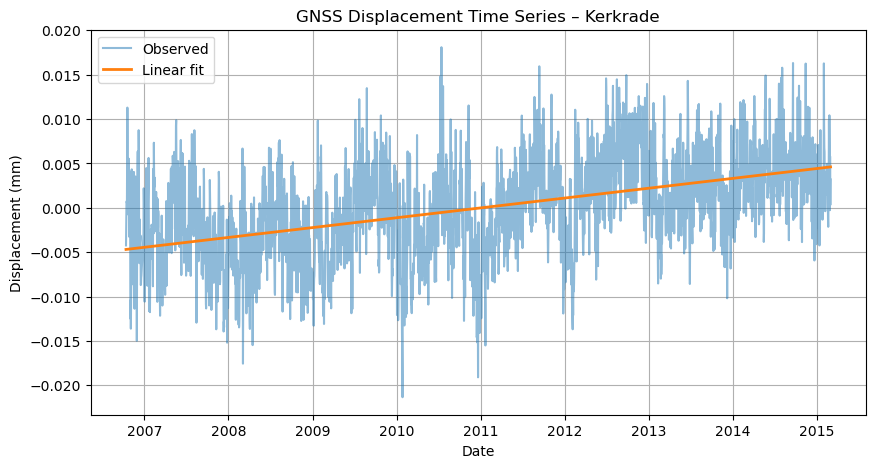

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(gnss_dates, gnss_u, label="Observed", alpha=0.5)
plt.plot(gnss_dates, linear_trend(gnss_t, *popt_lin),
         label="Linear fit", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Displacement (mm)")
plt.title(f"GNSS Displacement Time Series – {station_name}")
plt.legend()
plt.grid(True)
plt.show()


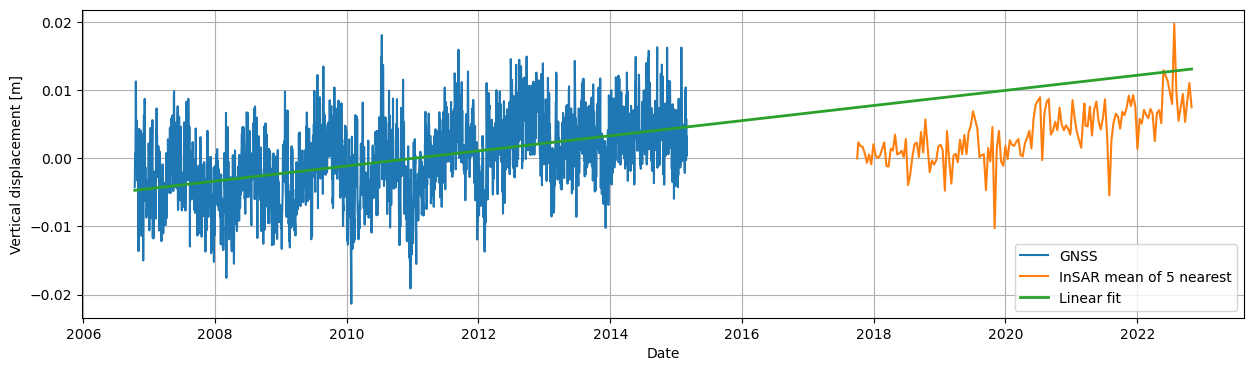

In [19]:
plt.figure(figsize=(15,4))
plt.plot(gnss_dates, gnss_u, label="GNSS")
plt.plot(insar_dates, insar_mean_u, label=f"InSAR mean of {N} nearest")
plt.plot(dates_full, linear_trend(t, *popt_lin), label="Linear fit", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Vertical displacement [m]")
plt.grid(True)
plt.legend()
plt.show()

In [32]:
# Calculate differences between InSAR observations and the linear trend

insar_fit_linear = linear_trend(insar_t, *popt_lin)
gnss_fit_linear = linear_trend(gnss_t, *popt_lin)

delta_u = np.abs(insar_mean_u - insar_fit_linear)

delta_u_mean = np.mean(delta_u)
print(f"Mean difference between InSAR data and linear trend: {delta_u_mean:.5f} mm")

insar_mean_u_shift = insar_mean_u + delta_u_mean

Mean difference between InSAR data and linear trend: 0.00686 mm


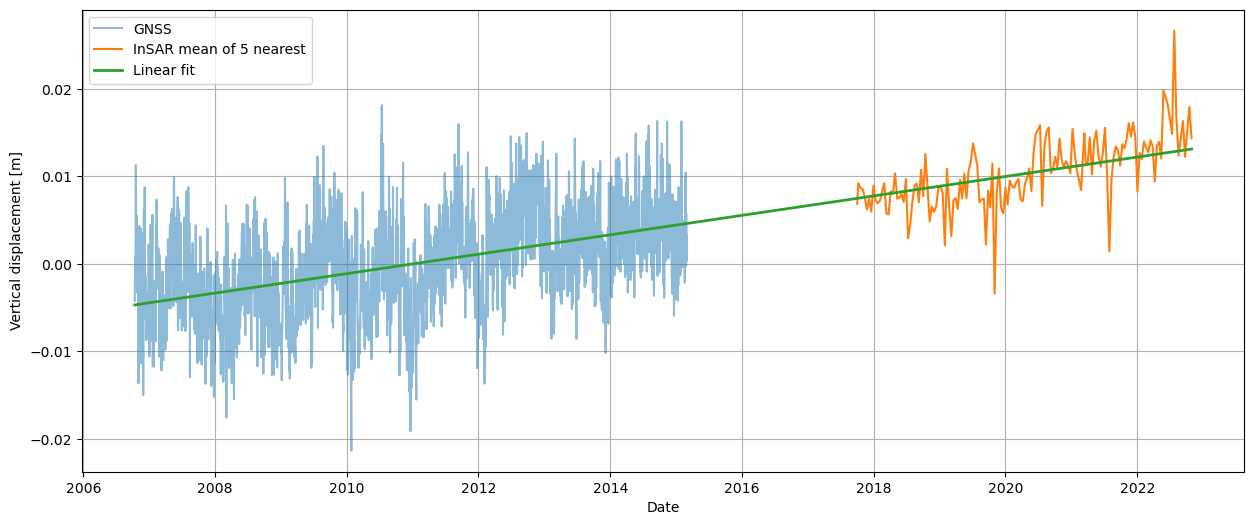

In [33]:
plt.figure(figsize=(15,6))
plt.plot(gnss_dates, gnss_u, label="GNSS", alpha=0.5)
plt.plot(insar_dates, insar_mean_u_shift, label=f"InSAR mean of {N} nearest")
plt.plot(dates_full, linear_trend(t, *popt_lin), label="Linear fit", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Vertical displacement [m]")
plt.grid(True)
plt.legend()
plt.show()

# Fit seasonal model

a = 2.9994707914518576e-06
b = -0.004583255760775055
c = -0.0019716155831540957
d = 0.0009237249869550779


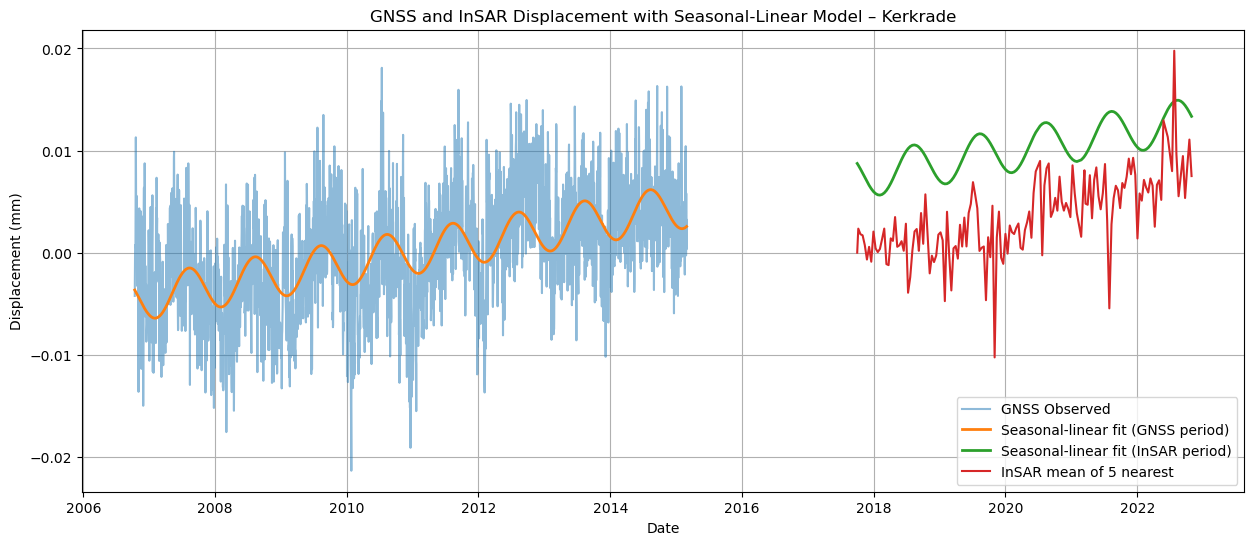

In [41]:
def seasonal_linear_trend(t, a, b, c, d):
     return a * t + b + c * np.sin(2/365.25 * np.pi * t ) + d * np.cos(2/365.25 * np.pi * t  )


# Fit parameters
params, covariance = curve_fit(seasonal_linear_trend, gnss_t, gnss_u)

# Extract parameters
a, b, c, d = params

print("a =", a)
print("b =", b)
print("c =", c)
print("d =", d)

# Compute fitted displacement
gnss_fit_seasonal = seasonal_linear_trend(gnss_t, a, b, c, d)


# Evaluate seasonal-linear model at InSAR dates
insar_fit_seasonal = seasonal_linear_trend(insar_t, a, b, c, d)

plt.figure(figsize=(15, 6))
plt.plot(gnss_dates, gnss_u, label="GNSS Observed", alpha=0.5)
plt.plot(gnss_dates, gnss_fit_seasonal, label="Seasonal-linear fit (GNSS period)", linewidth=2)
plt.plot(insar_dates, insar_fit_seasonal, label="Seasonal-linear fit (InSAR period)", linewidth=2)
plt.plot(insar_dates, insar_mean_u, label=f"InSAR mean of {N} nearest", markersize=3)
plt.xlabel("Date")
plt.ylabel("Displacement (mm)")
plt.title(f"GNSS and InSAR Displacement with Seasonal-Linear Model – {station_name}")
plt.legend()
plt.grid(True)
plt.show()

# Calculate mean difference between InSAR data and linear trend
insar_diff_seasonal = np.abs(np.mean(insar_mean_u - insar_fit_seasonal))
insar_shift_seasonal = insar_mean_u + insar_diff_seasonal

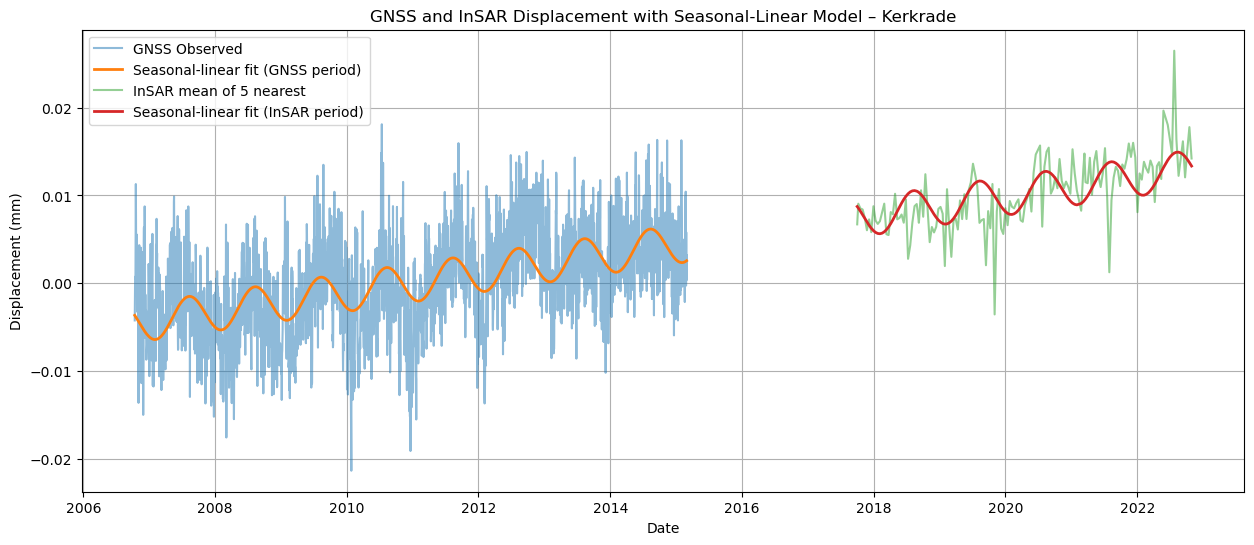

In [42]:
plt.figure(figsize=(15, 6))
plt.plot(gnss_dates, gnss_u, label="GNSS Observed", alpha=0.5)
plt.plot(gnss_dates, gnss_fit_seasonal, label="Seasonal-linear fit (GNSS period)", linewidth=2)
plt.plot(insar_dates, insar_shift_seasonal, label=f"InSAR mean of {N} nearest", markersize=3,alpha=0.5)
plt.plot(insar_dates, insar_fit_seasonal, label="Seasonal-linear fit (InSAR period)", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Displacement (mm)")
plt.title(f"GNSS and InSAR Displacement with Seasonal-Linear Model – {station_name}")
plt.legend()
plt.grid(True)
plt.show()

# Evalutation of fit

In [43]:
# Compare RMSE between Linear and Seonal-Linear fits
rmse_fit = np.sqrt(np.mean((gnss_u - gnss_fit_linear) ** 2))
print(f"RMSE between GNSS data and linear trend: {rmse_fit:.5f} mm")

rmse_seasonal = np.sqrt(np.mean((gnss_u - gnss_fit_seasonal) ** 2))
print(f"RMSE between GNSS data and seasonal-linear trend: {rmse_seasonal:.5f} mm")

# Percentage improvement
improvement = ((rmse_fit - rmse_seasonal) / rmse_fit) * 100
print(f"Percentage improvement in RMSE using seasonal-linear model: {improvement:.2f}%")

RMSE between GNSS data and linear trend: 0.00486 mm
RMSE between GNSS data and seasonal-linear trend: 0.00461 mm
Percentage improvement in RMSE using seasonal-linear model: 5.14%


In [47]:
# Compare RMSE between InSAR data
# Calculate the RSME between InSAR data and linear trend
rmse_lin = np.sqrt(np.mean((insar_mean_u_shift - insar_fit_linear) ** 2))
print(f"RMSE between InSAR data and linear trend: {rmse_lin:.5f} mm")

# Calculate the RSME between InSAR data and seasonal-linear trend
rmse_seasonal_insar = np.sqrt(np.mean((insar_shift_seasonal - insar_fit_seasonal) ** 2))
print(f"RMSE between InSAR data and seasonal-linear trend: {rmse_seasonal_insar:.5f} mm")

# Percentage improvement
improvement_insar = ((rmse_lin - rmse_seasonal_insar) / rmse_lin) * 100
print(f"Percentage improvement in RMSE using seasonal-linear model for InSAR data: {improvement_insar:.2f}%")

RMSE between InSAR data and linear trend: 0.00302 mm
RMSE between InSAR data and seasonal-linear trend: 0.00313 mm
Percentage improvement in RMSE using seasonal-linear model for InSAR data: -3.64%


# Ideas to continue

- Check the sign of the InSAR data
- Take the distance from the station into account in weighted technique
- Linear or model fit to the GNSS data
  - Constant model: $u_{GNSS} \approx u_{InSAR} + c$ and estimate c as the median of differences
  - Linear trend model: $u_{GNSS} \approx a + bt + u_{InSAR}$
  - Seasonal model : $u_{GNSS} \approx a + bt + Asin(2pit) + Bcos(2pit) + \epsilon$ then evaluate model at InSAR dates and estimate only on offset
- Data does not overlap
  - Option 1: Use the trend of the GNSS but is risky but OK for this assignment
  - Option 2: Make use of other GNSS stations that do have overlap



Assignment overall:
Part 1: Data integration
- Conversion of InSAR LOS to 'u'
- Datum alignment of the InSAR points using GNSS (working on this now)

Part 2: Anomaly detection
- Time-series modelling to get the acceleration
- Define anomalies
- Find anomalies